The purpose of this project is to use AOI images to train deep learning models to identify product surface defeats, including 6 categories(normal category + 5 defeat categories)
本議題所提供之影像資料，包含 6 個類別（正常類別 + 5 種瑕疵類別）。

下載資料 zip 檔案包含：

train_images.zip：訓練所需的影像資料（JPEG格式），共計 5,056 張。
train.csv：包含 2 個欄位，ID 和 Label。
ID：影像的檔名。
Label：瑕疵分類類別（0 表示 normal，1 表示 void，2 表示 horizontal defect，3 表示 vertical defect，4 表示 edge defect，5 表示 particle）。
test_images.zip：測試所需的影像資料（JPEG格式），共計 19,278 張。
test.csv：包含 1 個欄位，ID 。
ID：影像的檔名。
upload_sample.csv:上傳範例。包含 2 個欄位，ID 和 Label。
ID：影像的檔名。
Label：瑕疵分類類別（其值只能是下列其中之一：0、1、2、3、4、5）。

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random
import sys
import pandas as pd
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import cv2
import pandas as pd
from sklearn.utils import shuffle
from tensorflow.keras import layers

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
print (tf.__version__)

2.9.1


Download dataset by https://aidea-web.tw/topic/285ef3be-44eb-43dd-85cc-f0388bf85ea4

In [2]:
dirname  = './'
NUM_CLASSES = 6
# 影像類別名稱
class_names = ['normal', 'void', 'horizontal defect', 'vertical defect', 'edge defect', 'particle']
# 模型輸出儲存的檔案
WEIGHTS_FINAL = (dirname+'model-scratch-final.h5')

In [3]:
train_label = pd.read_csv('train.csv')
test_label = pd.read_csv('test.csv')
train_label_ID = train_label['ID'].values
test_label_ID = test_label['ID'].values
train_label_Label = train_label['Label'].values

In [4]:
print (test_label['Label'].values)

[nan nan nan ... nan nan nan]


In [5]:
class0 = []
class1 = []
class2 = []
class3 = []
class4 = []
class5 = []

for n, element in enumerate(train_label_ID):
    if train_label_Label[n] == 0 :
        class0.append(element)
    elif train_label_Label[n] == 1 :
        class1.append(element)
    elif train_label_Label[n] == 2 :
        class2.append(element)
    elif train_label_Label[n] == 3 :
        class3.append(element)
    elif train_label_Label[n] == 4 :
        class4.append(element)
    elif train_label_Label[n] == 5 :
        class5.append(element)
    
print ("Class0 Count of samples = {}".format(len(class0)))
print ("Class1 Count of samples = {}".format(len(class1)))
print ("Class2 Count of samples = {}".format(len(class2)))
print ("Class3 Count of samples = {}".format(len(class3)))
print ("Class4 Count of samples = {}".format(len(class4)))
print ("Class5 Count of samples = {}".format(len(class5)))
print ("Totel training samples = {}".format(len(train_label_Label)))

Class0 Count of samples = 674
Class1 Count of samples = 492
Class2 Count of samples = 100
Class3 Count of samples = 378
Class4 Count of samples = 240
Class5 Count of samples = 644
Totel training samples = 2528


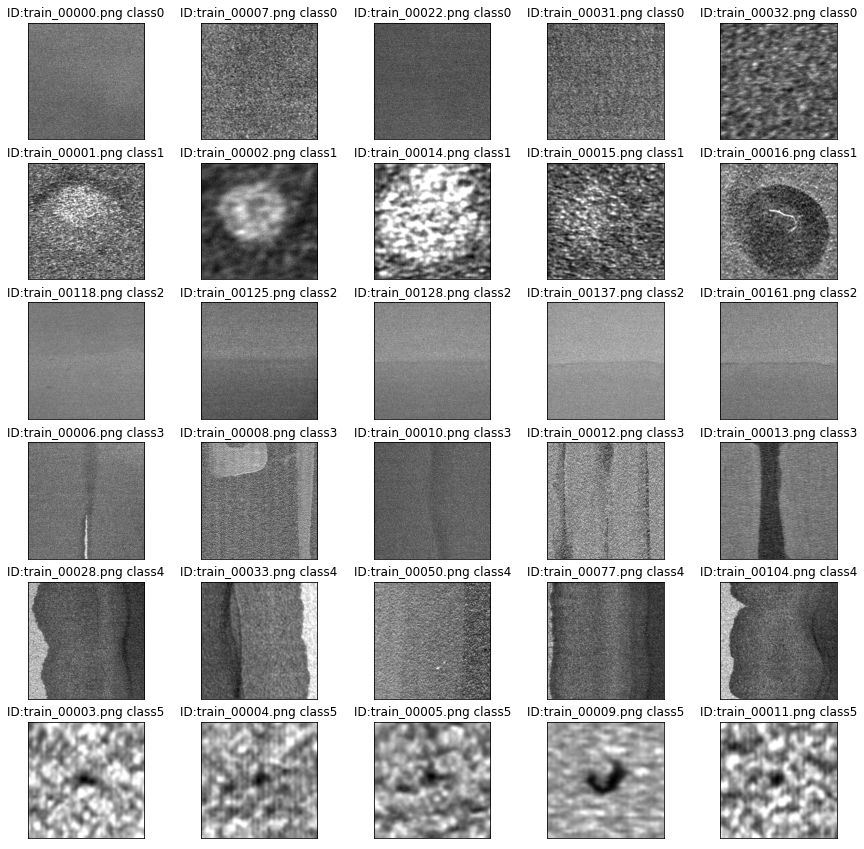

In [6]:
n = 5 #samples
plt.figure(figsize=(15,15))
for i in range(n):
    #
    ax = plt.subplot(6, n, i +1)
    name = class0[i]
    with Image.open(f'train_images/{name}') as img :
        plt.imshow(img,cmap='gray')
        plt.title('ID:'+name+' class0')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +6)
    name = class1[i]
    with Image.open(f'train_images/{name}') as img :
        plt.imshow(img,cmap='gray')
        plt.title('ID:'+name+' class1')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +11)
    name = class2[i]   
    with Image.open(f'train_images/{name}') as img :
        plt.imshow(img,cmap='gray')
        plt.title('ID:'+name+' class2')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +16)
    name = class3[i]
    with Image.open(f'train_images/{name}') as img :
        plt.imshow(img,cmap='gray')
        plt.title('ID:'+name+' class3')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +21)
    name = class4[i]
    with Image.open(f'train_images/{name}') as img :
        plt.imshow(img,cmap='gray')
        plt.title('ID:'+name+' class4')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +26)
    name = class5[i]
    with Image.open(f'train_images/{name}') as img :
        plt.imshow(img,cmap='gray')
        plt.title('ID:'+name+' class5')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Generate a Dataset

In [7]:
# Option1 -> the return to array dataset

def readfile(path, labels):
    # label 是一個 boolean variable，代表需不需要回傳 y 值
    image_dir = sorted(os.listdir(path))
    x = np.zeros((len(image_dir), 224, 224, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = image.load_img(path+"/"+file, target_size=(224, 224))
        x[i, :, :] = img
        if labels:
            y[i] = int(train_label_Label[i])
    if labels:
        return x, y
    else:
        return x
workspace_dir = 'train_images'
print("Reading data")
train_x, train_y = readfile('train_images', labels =True)

train_y = tf.one_hot(train_y, NUM_CLASSES)
print("Size of training data = {}".format(len(train_x)))

test_x = readfile('test_images', labels =False)
pred_y = test_label['Label'].values
print("Size of Testing data = {}".format(len(test_x)))

Reading data


2022-09-06 09:54:26.002747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 09:54:26.011421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 09:54:26.011583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 09:54:26.012137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Size of training data = 2528
Size of Testing data = 10142


In [8]:
# Put aside a few samples to create our validation set
val_samples = 200
x_val, y_val = train_x[:val_samples], train_y[:val_samples]
new_x_train, new_y_train = train_x[val_samples:], train_y[val_samples:]
train_ds_one = tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
train_ds_two = tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((test_x, pred_y))
print (len(list(train_ds_one.as_numpy_iterator())))

2328


Prepare tf.data.Dataset objects

In [9]:
image_size = 224
batch_size =64
AUTOTUNE = tf.data.AUTOTUNE

resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Resizing(image_size, image_size)
    ])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical")
    ])



def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds_one = prepare(train_ds_one, shuffle=True, augment=True)
train_ds_two = prepare(train_ds_two, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_zip = tf.data.Dataset.zip((train_ds_one, train_ds_two))

In [10]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

[0.0, 0.0, 0.0, 0.0, 0.9436268210411072, 0.05637317895889282]
[0.7043821215629578, 0.0, 0.0, 0.29561787843704224, 0.0, 0.0]
[0.7096041440963745, 0.2903958559036255, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.16938841342926025, 0.0, 0.8306115865707397]
[0.0, 0.9513104557991028, 0.0, 0.0, 0.04868954420089722, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[0.003513163421303034, 0.0, 0.0, 0.0, 0.9964868426322937, 0.0]
[0.9731056094169617, 0.02689437009394169, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


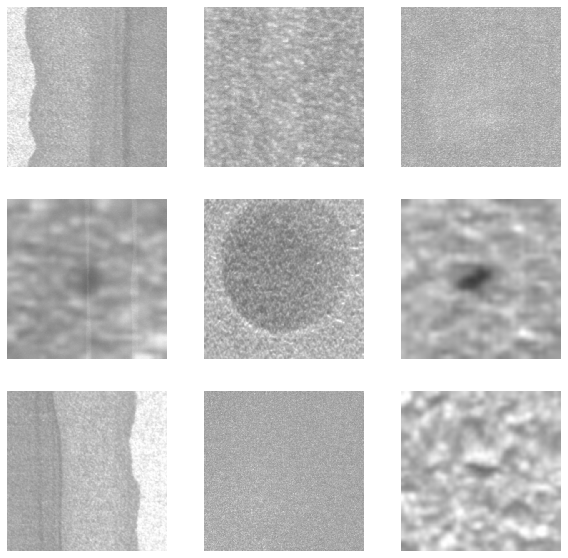

In [12]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_zip.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.4), num_parallel_calls=AUTOTUNE
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

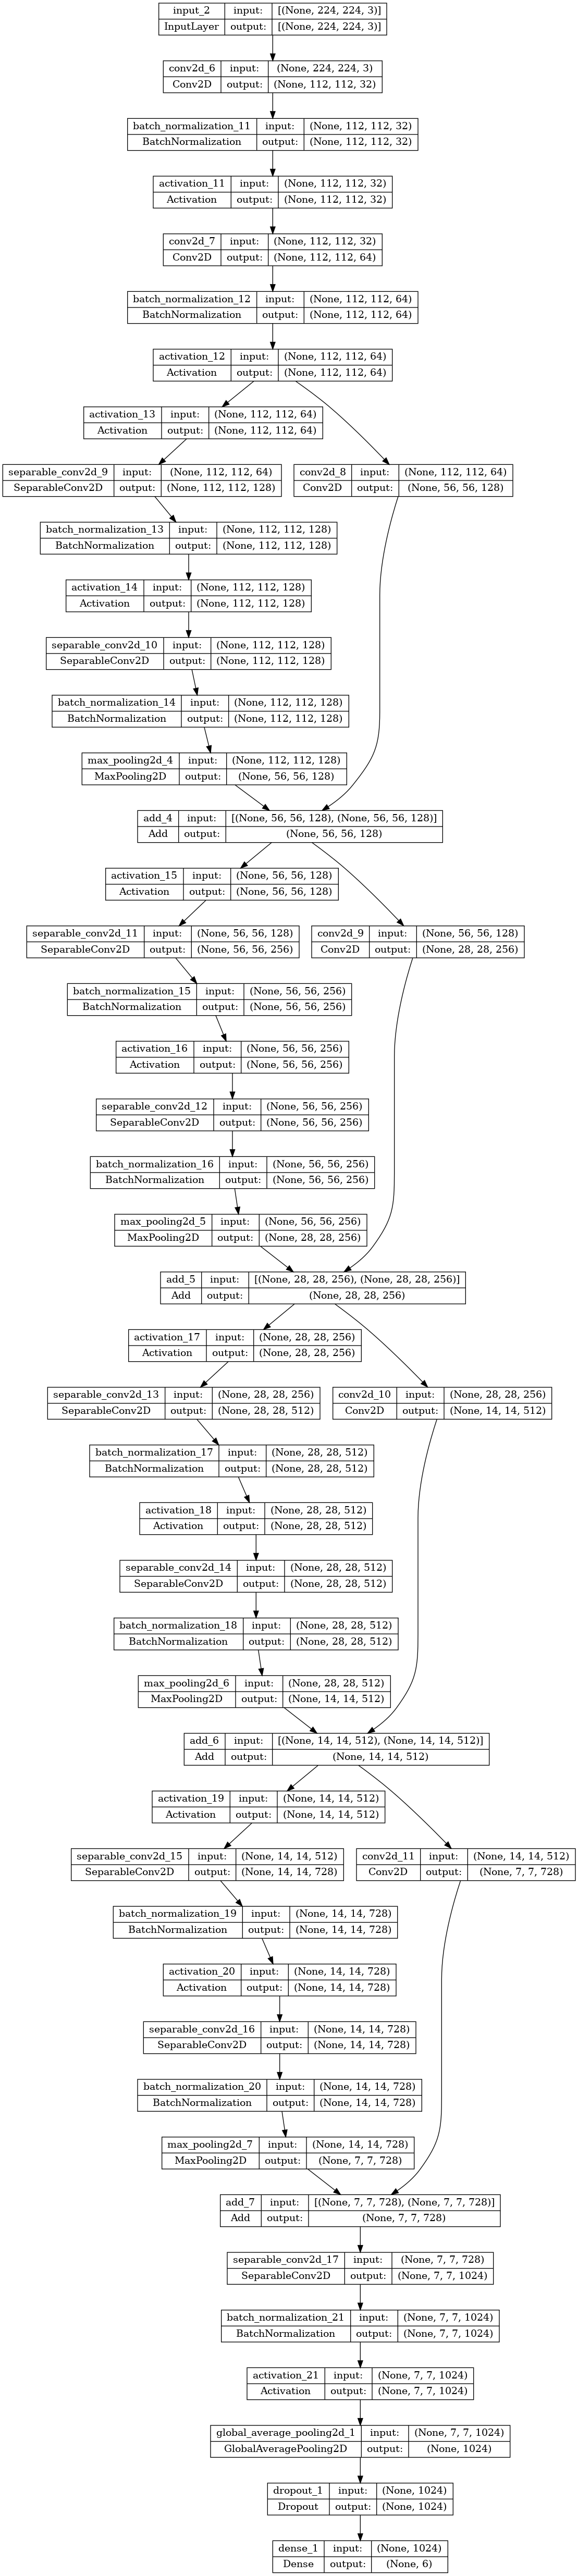

In [16]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(inputs, outputs)

net = make_model(input_shape=(image_size,image_size) + (3,), num_classes=6)
tf.keras.utils.plot_model(net, show_shapes=True)

In [17]:
learning_rate = 0.0001
epochs = 200
callback =tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True)
net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=['accuracy'])
history = net.fit(
    train_ds_mu,
    validation_data=val_ds,
    callbacks =[callback],
    epochs=epochs
    )

Epoch 1/200
37/37 [==============================] - 14s 322ms/step - loss: 1.2539 - accuracy: 0.5795 - val_loss: 1.7788 - val_accuracy: 0.2350
Epoch 2/200
37/37 [==============================] - 13s 311ms/step - loss: 0.9767 - accuracy: 0.7066 - val_loss: 1.7683 - val_accuracy: 0.2350
Epoch 3/200
37/37 [==============================] - 13s 312ms/step - loss: 0.8614 - accuracy: 0.7668 - val_loss: 1.7581 - val_accuracy: 0.2350
Epoch 4/200
37/37 [==============================] - 13s 306ms/step - loss: 0.8234 - accuracy: 0.7775 - val_loss: 1.7510 - val_accuracy: 0.2350
Epoch 5/200
37/37 [==============================] - 13s 308ms/step - loss: 0.8038 - accuracy: 0.8011 - val_loss: 1.7546 - val_accuracy: 0.2350
Epoch 6/200
37/37 [==============================] - 13s 309ms/step - loss: 0.7625 - accuracy: 0.8243 - val_loss: 1.7614 - val_accuracy: 0.2350
Epoch 7/200
37/37 [==============================] - 13s 312ms/step - loss: 0.7328 - accuracy: 0.8303 - val_loss: 1.7859 - val_accuracy:

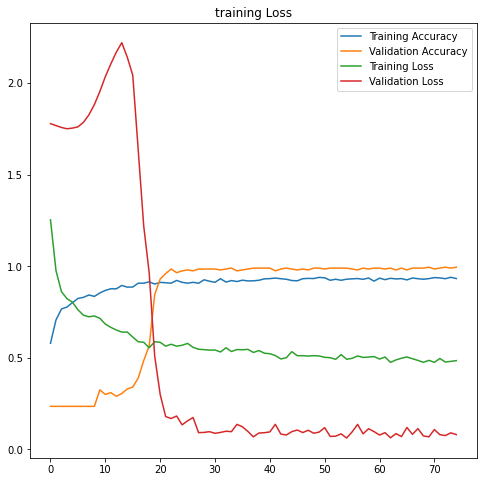

In [18]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history['val_accuracy']
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure(figsize=(8,8))
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title("training Loss")
plt.show()

In [21]:
# 儲存訓練好的模型
#mymodel.save(WEIGHTS_FINAL)

In [22]:
validation_loss,validation_acc = net.evaluate(val_ds)

4/4 [==============================] - 0s 28ms/step - loss: 0.0620 - accuracy: 0.9900


In [20]:
predictions = net.predict(test_ds)

159/159 [==============================] - 7s 39ms/step


In [23]:
print (predictions.shape)
np.argmax(predictions[0])

(10142, 6)


1

In [24]:
#將結果寫入 CSV 檔
with open('test_scratch.csv', 'w') as outfile:
    outfile.write('ID,Label\n')
    for i, y in enumerate(predictions):
        name = test_label_ID[i]
        pred = np.argmax(y)
        print (name,pred)
        outfile.write('{},{}\n'.format(name,pred))

test_00000.png 1
test_00001.png 2
test_00002.png 5
test_00003.png 0
test_00004.png 2
test_00005.png 5
test_00006.png 5
test_00007.png 5
test_00008.png 0
test_00009.png 2
test_00010.png 3
test_00011.png 0
test_00012.png 0
test_00013.png 1
test_00014.png 1
test_00015.png 0
test_00016.png 0
test_00017.png 5
test_00018.png 0
test_00019.png 0
test_00020.png 4
test_00021.png 1
test_00022.png 4
test_00023.png 5
test_00024.png 0
test_00025.png 0
test_00026.png 5
test_00027.png 0
test_00028.png 5
test_00029.png 5
test_00030.png 1
test_00031.png 5
test_00032.png 4
test_00033.png 1
test_00034.png 2
test_00035.png 4
test_00036.png 1
test_00037.png 3
test_00038.png 0
test_00039.png 1
test_00040.png 2
test_00041.png 5
test_00042.png 4
test_00043.png 1
test_00044.png 5
test_00045.png 5
test_00046.png 0
test_00047.png 4
test_00048.png 3
test_00049.png 3
test_00050.png 5
test_00051.png 5
test_00052.png 5
test_00053.png 4
test_00054.png 0
test_00055.png 0
test_00056.png 0
test_00057.png 0
test_00058.png